# Perceptron

## References

https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

## Import Python Libraries

In [691]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample

## Global Variables

In [692]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [693]:
# Sources: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: row #
# X02: id
# X03: Gender: Gender of the passengers (Female, Male)
# X04: Customer Type: The customer type (Loyal customer, disloyal customer)
# X05: Age: The actual age of the passengers
# X06: Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
# X07: Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
# X08: Flight distance: The flight distance of this journey
# X09: Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
# X10: Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient
# X11: Ease of Online booking: Satisfaction level of online booking
# X12: Gate location: Satisfaction level of Gate location
# X13: Food and drink: Satisfaction level of Food and drink
# X14: Online boarding: Satisfaction level of online boarding
# X15: Seat comfort: Satisfaction level of Seat comfort
# X16: Inflight entertainment: Satisfaction level of inflight entertainment
# X17: On-board service: Satisfaction level of On-board service
# X18: Leg room service: Satisfaction level of Leg room service
# X19: Baggage handling: Satisfaction level of baggage handling
# X20: Check-in service: Satisfaction level of Check-in service
# X21: Inflight service: Satisfaction level of inflight service
# X22: Cleanliness: Satisfaction level of Cleanliness
# X23: Departure Delay in Minutes: Minutes delayed when departure
# X24: Arrival Delay in Minutes: Minutes delayed when Arrival
#   y: Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

In [694]:
# load train dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/airline_satisfaction_train.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [695]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'satisfaction'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [696]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [697]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X01     103904 non-null  int64  
 1   X02     103904 non-null  int64  
 2   X03     103904 non-null  object 
 3   X04     103904 non-null  object 
 4   X05     103904 non-null  int64  
 5   X06     103904 non-null  object 
 6   X07     103904 non-null  object 
 7   X08     103904 non-null  int64  
 8   X09     103904 non-null  int64  
 9   X10     103904 non-null  int64  
 10  X11     103904 non-null  int64  
 11  X12     103904 non-null  int64  
 12  X13     103904 non-null  int64  
 13  X14     103904 non-null  int64  
 14  X15     103904 non-null  int64  
 15  X16     103904 non-null  int64  
 16  X17     103904 non-null  int64  
 17  X18     103904 non-null  int64  
 18  X19     103904 non-null  int64  
 19  X20     103904 non-null  int64  
 20  X21     103904 non-null  int64  
 21  X22     10

In [698]:
# describe data
df1.describe()

,X01,X02,X05,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [699]:
# check missing values
df1.isna().sum()

X01      0
X02      0
X03      0
X04      0
X05      0
X06      0
X07      0
X08      0
X09      0
X10      0
X11      0
X12      0
X13      0
X14      0
X15      0
X16      0
X17      0
X18      0
X19      0
X20      0
X21      0
X22      0
X23      0
X24    310
y        0
dtype: int64

## Data Cleaning and Transformation

In [700]:
# drop useless columns
drop_id = ['X01', 'X02']
df1 = df1.drop(columns = drop_id, errors = 'ignore')

df1.head()

,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [701]:
# response column
y_col = new_y_col
y_col

'y'

In [702]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11', 'X12',
       'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22',
       'X23', 'X24'],
      dtype='object')

In [703]:
# get unique y_labels
y_labels = df1.y.unique()
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'neutral or dissatisfied': 0, 'satisfied': 1}

In [704]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [705]:
# remove rows with missing valus
for X in X_cols:
  cond1 = ~((df1[X].isna()))
  df1 = df1.loc[cond1,:]
  
df1.isna().sum()

X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
X24    0
y      0
dtype: int64

In [706]:
# encode categorical values to numerical values
le = LabelEncoder()

categorical_cols = df1[X_cols].select_dtypes("object").columns
df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

df1.head()

,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,1,0,13,1,2,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,1,1,25,0,0,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,0,0,26,0,0,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,0,0,25,0,0,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,1,0,61,0,0,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [707]:
# # check label distribution
# temp = list(y_labels.values())
# cond1 = df1.y == temp[0]
# cond2 = df1.y == temp[1]

# n_1 = np.sum(cond1)
# print(temp[0])
# print(n_1)

# n_2 = np.sum(cond2)
# print(temp[1])
# print(n_2)

# # upsample minority label
# df_temp = df1.loc[cond2,:]
# n_diff = n_1 - n_2
# print(n_diff)

# df_upsample = resample(
#   df_temp,
#   replace = True,
#   n_samples = n_diff,
#   random_state = random_state
# )

# # update df1
# df1 = pd.concat([df1, df_upsample], ignore_index = True)
# df1.info()

In [708]:
# # check label distribution
# temp = list(y_labels.values())
# cond1 = df1.y == temp[0]
# cond2 = df1.y == temp[1]

# n_1 = np.sum(cond1)
# print(temp[0])
# print(n_1)

# n_2 = np.sum(cond2)
# print(temp[1])
# print(n_2)

# # downsample majority label
# df_temp = df1.loc[cond1,:]
# n_diff = n_1 - n_2
# print(n_diff)

# df_upsample = resample(
#   df_temp,
#   replace = False,
#   n_samples = n_diff,
#   random_state = random_state
# )

# # # update df1
# df1 = df1.drop(df_upsample.index)
# df1.info()

In [709]:
# normalize all X_cols
df2 = df1.copy()
# norm = StandardScaler()
# norm = MinMaxScaler()
norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,1.0,0.0,-1.125000,1.0,1.0,-0.287434,0.0,0.5,0.0,-1.0,...,0.5,0.0,-0.5,0.0,1.0,0.5,1.0,2.083333,1.384615,0
1,1.0,1.0,-0.625000,0.0,-1.0,-0.456734,0.0,-0.5,0.0,0.0,...,-1.5,-1.5,0.5,-0.5,-2.0,0.0,-1.0,0.083333,0.461538,0
2,0.0,0.0,-0.583333,0.0,-1.0,0.225734,-0.5,-0.5,-0.5,-0.5,...,0.5,0.0,-0.5,0.0,1.0,0.0,1.0,0.000000,0.000000,1
3,0.0,0.0,-0.625000,0.0,-1.0,-0.210685,-0.5,1.0,1.0,1.0,...,-1.0,-1.0,0.5,-0.5,-2.0,0.0,-0.5,0.916667,0.692308,0
4,1.0,0.0,0.875000,0.0,-1.0,-0.472536,0.0,0.0,0.0,0.0,...,-0.5,-0.5,0.0,0.0,0.0,-0.5,0.0,0.000000,0.000000,1


In [710]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

In [711]:
# melt df2 into a dataframe where cols become stacked as rows
df3 = df2.melt(
  id_vars = y_col,
  value_vars = X_cols,
  var_name = 'X',
  value_name = "X_value"
)
df3.head()

,y,X,X_value
0,0,X03,1.0
1,0,X03,1.0
2,1,X03,0.0
3,0,X03,0.0
4,1,X03,1.0


## Visualize Dataset

In [712]:
# figure setup
fig_cols = 5
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (30, 15)

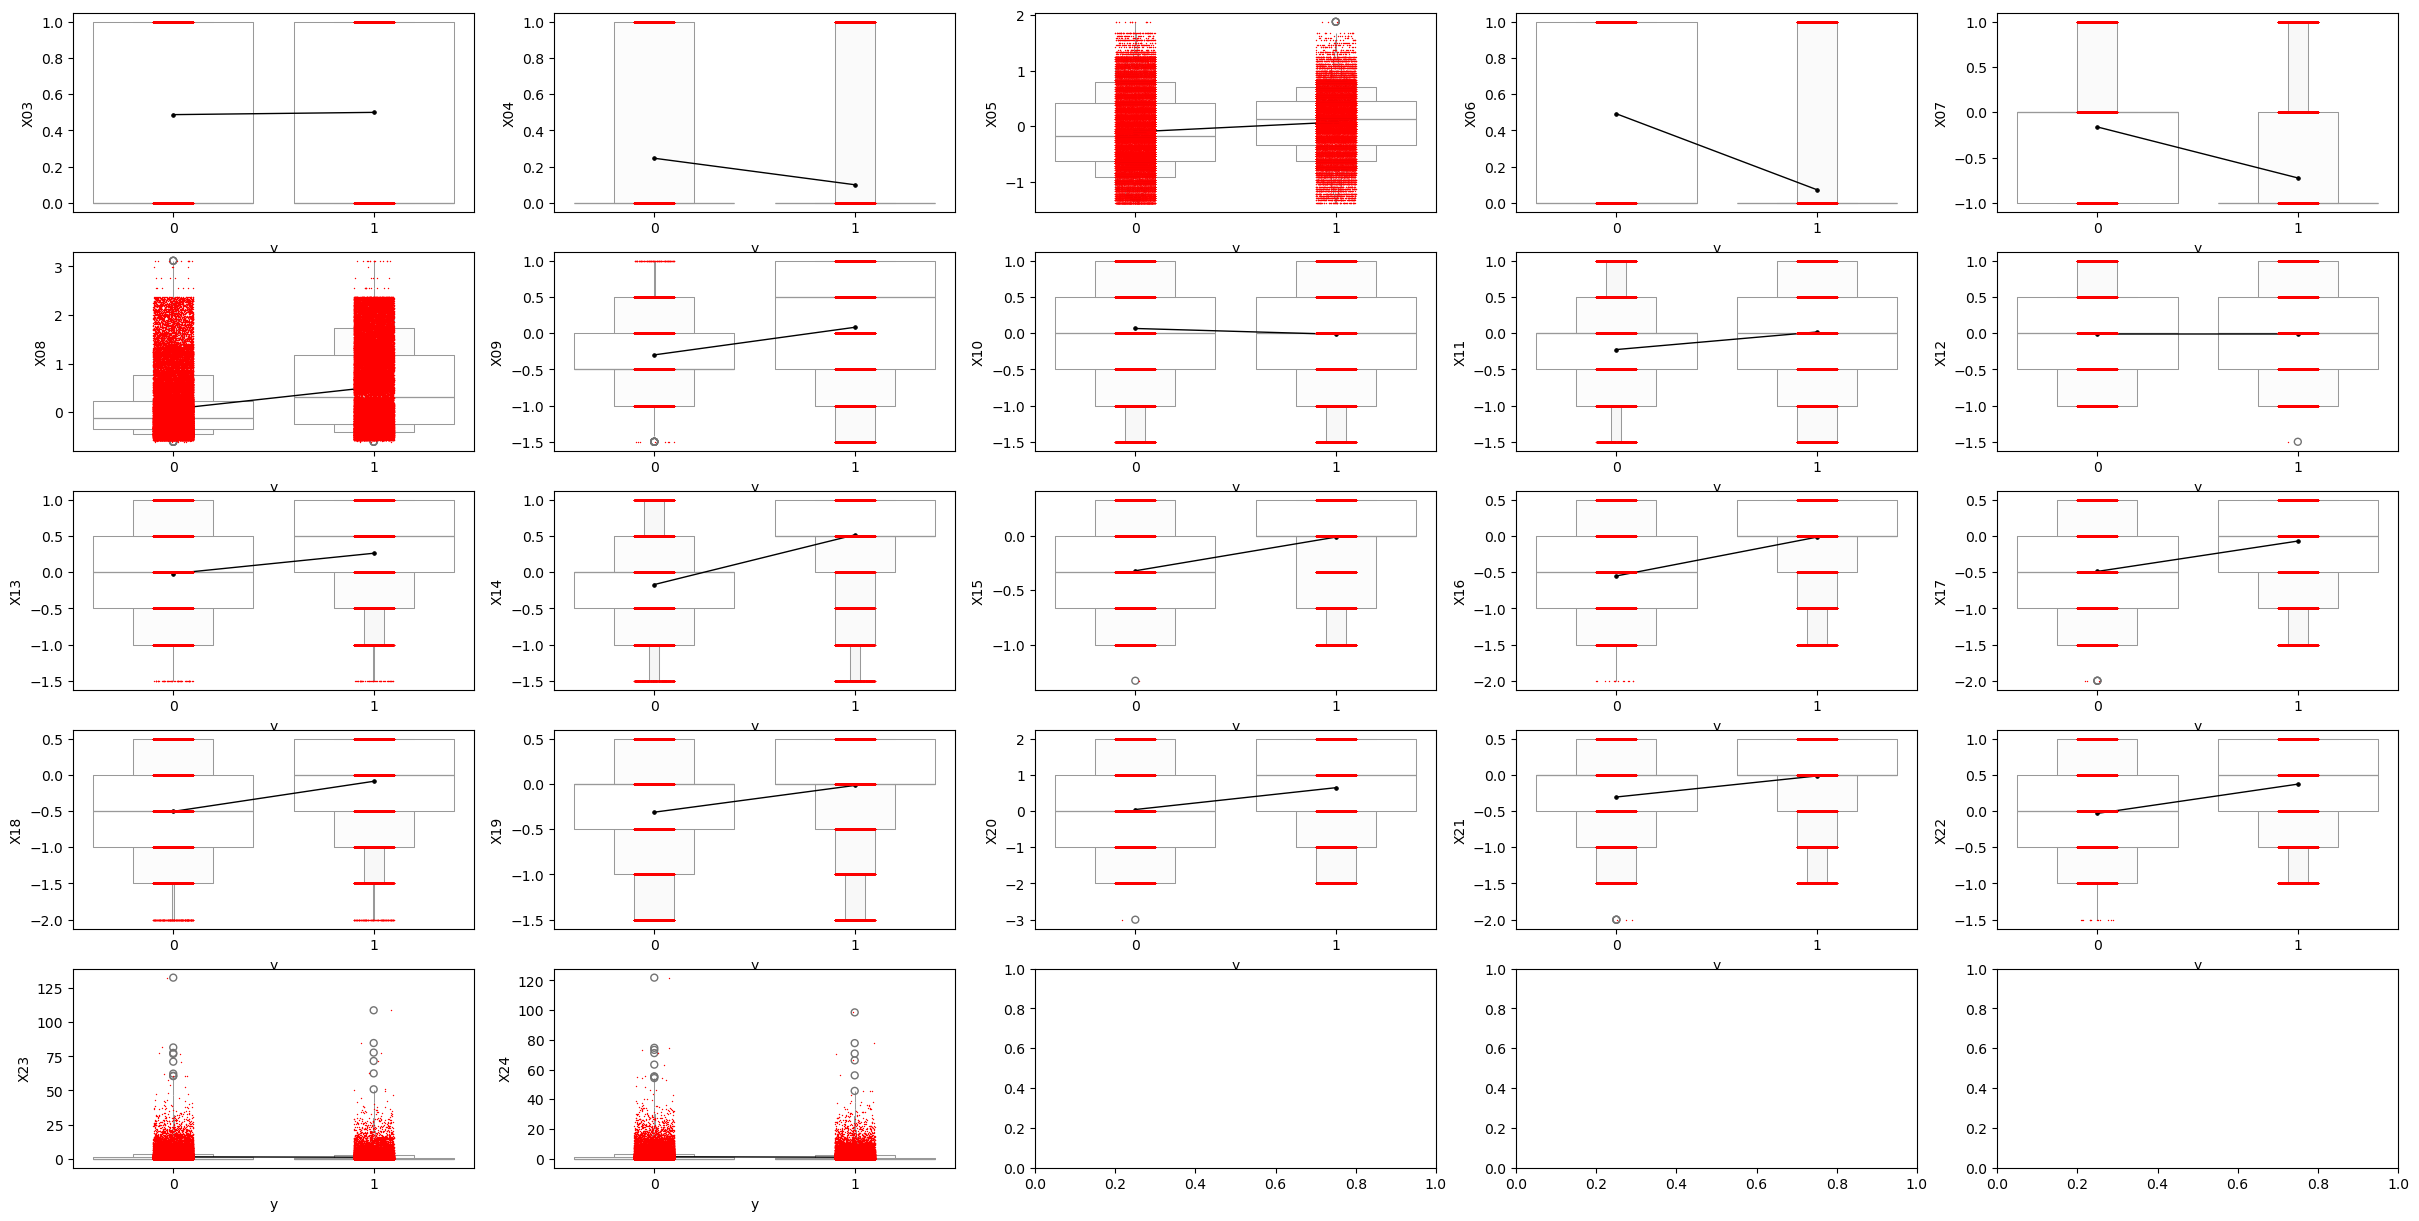

In [713]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Remove Features Having % Similar Values or More

In [714]:
# porportion similar (p)
p = 1
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

1 0


In [715]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [716]:
# fit model
temp = myfit.fit_transform(df2[X_cols])
temp.shape

(103594, 22)

In [717]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X24'], dtype=object)

In [718]:
# update X_cols
X_cols = X_cols_var_threshold
X_cols

array(['X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X24'], dtype=object)

### Select Features Using Model Selection Methods

In [719]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [720]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 4,
  # max_depth = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [721]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [722]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.00390598, 0.05254456, 0.04865222, 0.08510216, 0.08983606,
       0.02961357, 0.17628721, 0.01564796, 0.04202517, 0.01481283,
       0.01455805, 0.10467117, 0.03517627, 0.06708856, 0.01801378,
       0.07539028, 0.04019248, 0.02605141, 0.01869623, 0.01893951,
       0.01079401, 0.01200054])

In [723]:
# threshold feature importance
# feature_importance_threshold = np.mean(feature_importance)
feature_importance_threshold = np.median(feature_importance)
# feature_importance_threshold = np.quantile(feature_importance, q = 0.75)
feature_importance_threshold

0.03239492113436879

In [724]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = feature_importance_threshold
)

In [725]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [726]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X04', 'X05', 'X06', 'X07', 'X09', 'X11', 'X14', 'X15', 'X16',
       'X18', 'X19'], dtype=object)

## Train and Test ML Model

In [727]:
# X_cols to include after feature selection
# X_include = X.columns
X_include = X_cols_rf
print(len(X_include))
print(X_include)

11
['X04' 'X05' 'X06' 'X07' 'X09' 'X11' 'X14' 'X15' 'X16' 'X18' 'X19']


In [728]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X[X_include], y, 
  # stratify = y, shuffle = True, 
  train_size = 0.7, random_state = random_state
)

In [729]:
# initialize Decision Tree model
myfit = Perceptron(
  fit_intercept = True,
  max_iter = 10000,
  eta0 = 1E-7,
  random_state = random_state
)

In [730]:
# fit model
temp = myfit.fit(X_train, y_train)

In [731]:
# get predictions on test data
y_hat = myfit.predict(X_test)

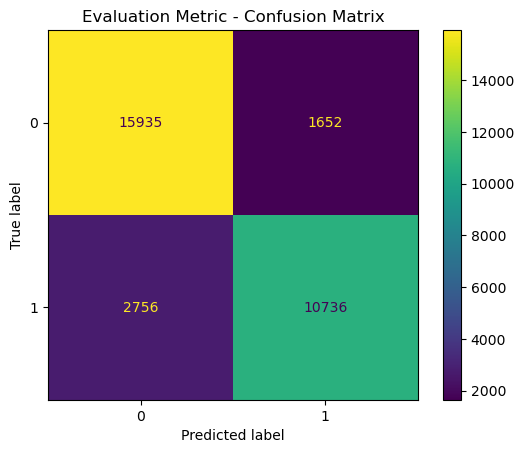

In [732]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [733]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     17587
           1       0.87      0.80      0.83     13492

    accuracy                           0.86     31079
   macro avg       0.86      0.85      0.85     31079
weighted avg       0.86      0.86      0.86     31079



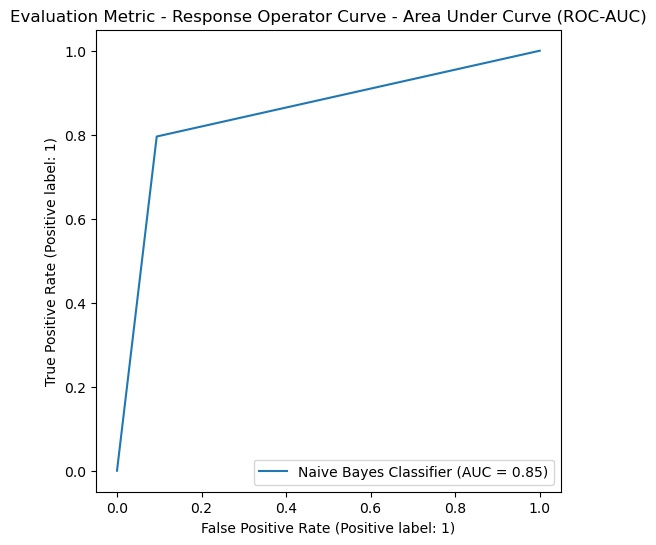

In [734]:
# model evaluation - AUC
fig, ax = plt.subplots(figsize = (6, 6))
RocCurveDisplay.from_predictions(ax = ax,
  y_true = y_test, y_pred = y_hat, pos_label = 1,
  name = "Naive Bayes Classifier"
)
plt.title('Evaluation Metric - Response Operator Curve - Area Under Curve (ROC-AUC)')
plt.show()

## Test ML Model On New Data

In [735]:
# load test dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/airline_satisfaction_test.csv'
df_test = pd.read_csv(filepath1, header = 0)
df_test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [736]:
# standardize column names
df_test.columns = new_all_cols

df_test.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [737]:
# check data structure
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     25976 non-null  int64  
 1   X02     25976 non-null  int64  
 2   X03     25976 non-null  object 
 3   X04     25976 non-null  object 
 4   X05     25976 non-null  int64  
 5   X06     25976 non-null  object 
 6   X07     25976 non-null  object 
 7   X08     25976 non-null  int64  
 8   X09     25976 non-null  int64  
 9   X10     25976 non-null  int64  
 10  X11     25976 non-null  int64  
 11  X12     25976 non-null  int64  
 12  X13     25976 non-null  int64  
 13  X14     25976 non-null  int64  
 14  X15     25976 non-null  int64  
 15  X16     25976 non-null  int64  
 16  X17     25976 non-null  int64  
 17  X18     25976 non-null  int64  
 18  X19     25976 non-null  int64  
 19  X20     25976 non-null  int64  
 20  X21     25976 non-null  int64  
 21  X22     25976 non-null  int64  
 22

In [738]:
# describe data
df_test.describe()

,X01,X02,X05,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25893.000000
mean,12987.500000,65005.657992,39.620958,1193.788459,2.724746,3.046812,2.756775,2.977094,3.215353,3.261665,3.449222,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.740857
std,7498.769632,37611.526647,15.135685,998.683999,1.335384,1.533371,1.412951,1.282133,1.331506,1.355536,1.320090,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.517539
min,0.000000,17.000000,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,6493.750000,32170.500000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000
50%,12987.500000,65319.500000,40.000000,849.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000
75%,19481.250000,97584.250000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000
max,25975.000000,129877.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.00000,1115.000000


In [739]:
# check missing values
df_test.isna().sum()

X01     0
X02     0
X03     0
X04     0
X05     0
X06     0
X07     0
X08     0
X09     0
X10     0
X11     0
X12     0
X13     0
X14     0
X15     0
X16     0
X17     0
X18     0
X19     0
X20     0
X21     0
X22     0
X23     0
X24    83
y       0
dtype: int64

In [740]:
# drop useless columns
drop_id = ['X01', 'X02']
df_test = df_test.drop(columns = drop_id, errors = 'ignore')

df_test.head()

,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [741]:
# rename y_labels
df_test.y = df_test.y.replace(y_labels)
df_test.head()

,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,1
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,1
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,0
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,1
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,1


In [742]:
# remove rows with missing valus
for X in X_cols:
  cond1 = ~((df_test[X].isna()))
  df_test = df_test.loc[cond1,:]
  
df_test.isna().sum()

X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
X24    0
y      0
dtype: int64

In [743]:
# encode categorical values to numerical values
df_test[categorical_cols] = df_test[categorical_cols].apply(le.fit_transform)
df_test.head()

,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,0,0,52,0,1,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,1
1,0,0,36,0,0,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,1
2,1,1,20,0,1,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,0
3,1,0,44,0,0,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,1
4,0,0,49,0,1,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,1


In [744]:
# normalize all X_cols
df_test[X_cols] = norm.fit_transform(df_test[X_cols])

df_test.head()

,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,y
0,0.0,0.0,0.500000,0.0,0.0,-0.518045,1.0,0.5,0.0,0.5,...,0.5,0.5,0.5,0.5,-1.0,0.5,1.0,4.166667,3.384615,1
1,0.0,0.0,-0.166667,0.0,-1.0,1.514286,-1.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1
2,1.0,1.0,-0.833333,0.0,0.0,-0.493985,-0.5,-1.5,-0.5,0.5,...,-1.0,0.0,-1.5,-0.5,-1.0,-1.0,-0.5,0.000000,0.000000,0
3,1.0,0.0,0.166667,0.0,-1.0,1.900752,-1.5,-1.5,-1.5,-0.5,...,-1.5,-1.5,-1.5,-1.5,0.0,-1.5,0.5,0.000000,0.461538,1
4,0.0,0.0,0.375000,0.0,0.0,0.250376,-0.5,0.0,0.5,0.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,0.5,0.000000,1.538462,1


In [745]:
# seperate data into X_test2 and y_test2
X_test2 = df_test[X_include]
y_test2 = np.ravel(df_test[y_col])

In [746]:
# get predictions on test data
y_hat2 = myfit.predict(X_test2)

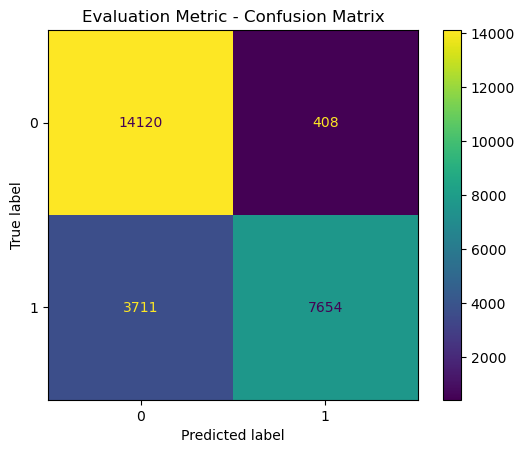

In [747]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test2,
  y_pred = y_hat2
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [748]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test2, y_pred = y_hat2, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           0       0.79      0.97      0.87     14528
           1       0.95      0.67      0.79     11365

    accuracy                           0.84     25893
   macro avg       0.87      0.82      0.83     25893
weighted avg       0.86      0.84      0.84     25893



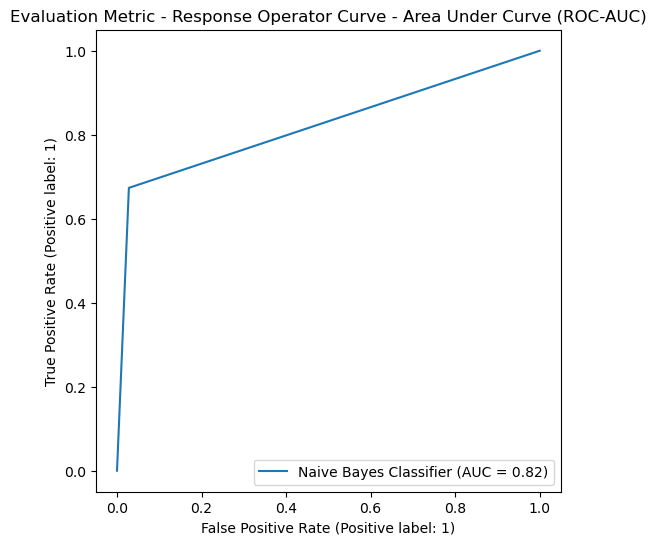

In [749]:
# model evaluation - AUC
fig, ax = plt.subplots(figsize = (6, 6))
RocCurveDisplay.from_predictions(ax = ax,
  y_true = y_test2, y_pred = y_hat2, pos_label = 1,
  name = "Naive Bayes Classifier"
)
plt.title('Evaluation Metric - Response Operator Curve - Area Under Curve (ROC-AUC)')
plt.show()